In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from matplotlib.dates import DateFormatter

In [2]:
energy = pd.read_csv("energy_dataset.csv")
weather = pd.read_csv("weather_features.csv")

In [3]:
# Checking for null values and types in dataframe.

#energy.info()
#energy.isna().sum()

In [4]:
#Temporarly removing "time" column to better handle the nulls, will be hading it latter again.

time_df = pd.DataFrame(data = energy["time"])
#time_df

In [5]:
# Dropping columns we don't need.

energy = energy.drop(["time", "generation fossil coal-derived gas", "generation fossil oil shale", "generation fossil peat", "generation geothermal", "generation marine", "generation wind offshore", "generation hydro pumped storage aggregated", "forecast wind offshore eday ahead"], axis = 1)

In [6]:
# Filling all the nulls values remaining

def impute_missing_values(energy):
    for column in energy:
        energy.loc[:,column] = np.where(energy[column].isna(), energy[column].mean(), energy[column])
    return energy
                
impute_missing_values(energy)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,96.0,3253.0,30619.0,30653.0,68.85,77.02
35060,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,51.0,3353.0,29932.0,29735.0,68.40,76.16
35061,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,36.0,3404.0,27903.0,28071.0,66.88,74.30
35062,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,93.0,31.0,287.0,3586.0,29.0,3273.0,25450.0,25801.0,63.93,69.89


In [7]:
#Divided all values by 5 cities.

energy = energy/5
#energy

In [8]:
# Hading back the colum to our cleaned dataset.

energy = time_df.join(energy)
#energy

In [9]:
# Re-checking for nulls.

#energy.isna().sum()

# No nulls good to go!

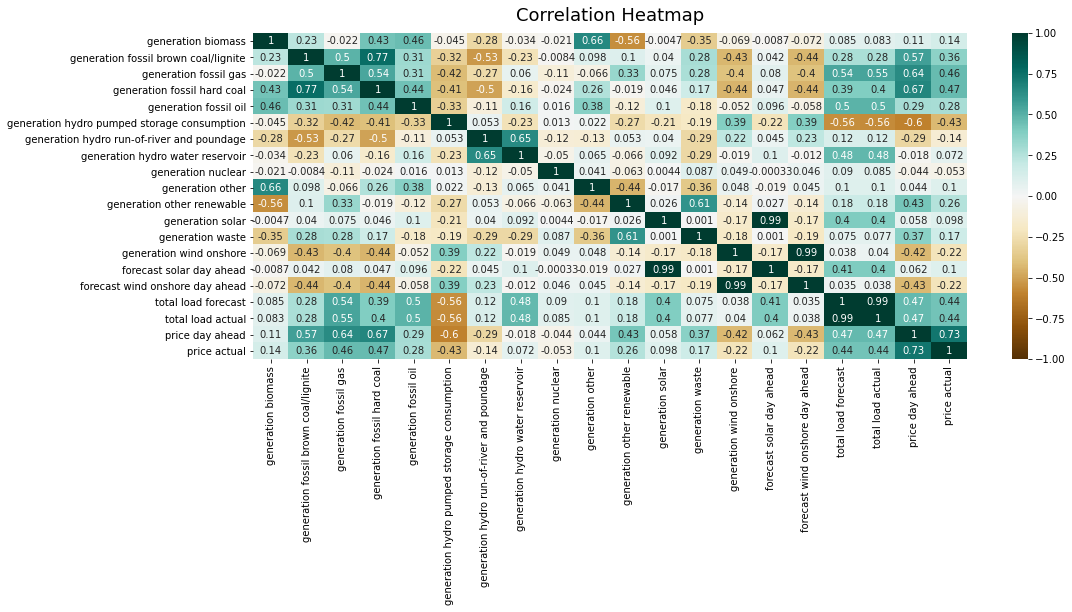

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(energy.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [11]:
# Checking for null values and types in dataframe.

weather.info()

# No nulls good to go!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [12]:
#weather

In [13]:
# Droping collums we don't need

weather = weather.drop(["weather_icon", "weather_id", "weather_description"], axis = 1)

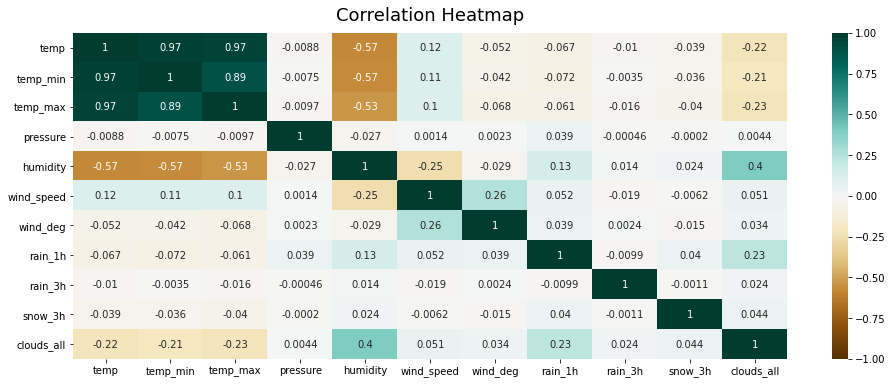

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(weather.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [15]:
# Merging data frames

sample = energy.merge(weather, left_on="time", right_on="dt_iso")

In [16]:
sample

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main
0,2015-01-01 00:00:00+01:00,89.4,65.8,968.8,964.2,32.4,172.6,210.2,379.8,1419.2,...,270.475000,1001,77,1,62,0.0,0.0,0.0,0,clear
1,2015-01-01 00:00:00+01:00,89.4,65.8,968.8,964.2,32.4,172.6,210.2,379.8,1419.2,...,267.325000,971,63,1,309,0.0,0.0,0.0,0,clear
2,2015-01-01 00:00:00+01:00,89.4,65.8,968.8,964.2,32.4,172.6,210.2,379.8,1419.2,...,269.657312,1036,97,0,226,0.0,0.0,0.0,0,clear
3,2015-01-01 00:00:00+01:00,89.4,65.8,968.8,964.2,32.4,172.6,210.2,379.8,1419.2,...,281.625000,1035,100,7,58,0.0,0.0,0.0,0,clear
4,2015-01-01 00:00:00+01:00,89.4,65.8,968.8,964.2,32.4,172.6,210.2,379.8,1419.2,...,273.375000,1039,75,1,21,0.0,0.0,0.0,0,clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 23:00:00+01:00,58.0,0.0,1385.2,433.2,32.6,21.6,213.8,337.2,1215.0,...,280.150000,1029,75,2,300,0.0,0.0,0.0,0,clear
178392,2018-12-31 23:00:00+01:00,58.0,0.0,1385.2,433.2,32.6,21.6,213.8,337.2,1215.0,...,275.150000,1031,74,1,360,0.0,0.0,0.0,0,clear
178393,2018-12-31 23:00:00+01:00,58.0,0.0,1385.2,433.2,32.6,21.6,213.8,337.2,1215.0,...,276.150000,1034,93,2,100,0.0,0.0,0.0,0,clear
178394,2018-12-31 23:00:00+01:00,58.0,0.0,1385.2,433.2,32.6,21.6,213.8,337.2,1215.0,...,283.150000,1028,100,5,310,0.0,0.0,0.0,0,clear


In [17]:
# Droping "duplicade" columns

sample = sample.drop(["dt_iso"], axis =1)

In [18]:
# Checking uniques values for one hot encoding

#sample["weather_main"].unique()

In [22]:
# Checking for null values and types in dataframe.

sample.info()

# No nulls, good to go!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178396 entries, 0 to 178395
Data columns (total 34 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   time                                         178396 non-null  object 
 1   generation biomass                           178396 non-null  float64
 2   generation fossil brown coal/lignite         178396 non-null  float64
 3   generation fossil gas                        178396 non-null  float64
 4   generation fossil hard coal                  178396 non-null  float64
 5   generation fossil oil                        178396 non-null  float64
 6   generation hydro pumped storage consumption  178396 non-null  float64
 7   generation hydro run-of-river and poundage   178396 non-null  float64
 8   generation hydro water reservoir             178396 non-null  float64
 9   generation nuclear                           178396 non-nul

In [ ]:
sample.info()